In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
df = pd.read_csv('../data/final_preprocessed_data_points.csv')
print(df.shape)
df.head(2)

(219, 23)


,_id,image_url,brands,pnns_groups_2,energy-kj_100g,sugars_100g,salt_100g,saturated-fat_100g,proteins_100g,fiber_100g,...,nutrition_grade_fr,negative_points,positive_points,energy_points,sugars_points,sodium_points,saturated_fat_points,fruit_points,fiber_points,proteins_points
0,3.251492e+12,https://images.openfoodfacts.org/images/produc...,Gerblé,Biscuits and cakes,1817.0,21.0,0.00,1.3,9.4,6.4,...,b,10.0,10.0,5,4,0,1,0,5,5
1,3.175680e+12,https://images.openfoodfacts.org/images/produc...,Gerblé,Biscuits and cakes,1961.0,17.0,0.38,2.0,10.0,4.6,...,b,10.0,9.0,5,3,0,1,0,4,5


In [22]:
en = "energy-kj_100g"
su = "sugars_100g"
fa = "saturated-fat_100g"
sa = "sodium_100g"
pr = "proteins_100g"
fi = "fiber_100g"
fr = "fruits-vegetables-nuts-estimate-from-ingredients_100g"

profiles = df.loc[:,[en, su, fa, sa, pr, fi, fr]]
print(profiles.shape)
profiles.head(2)

(219, 7)


,energy-kj_100g,sugars_100g,saturated-fat_100g,sodium_100g,proteins_100g,fiber_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g
0,1817.0,21.0,1.3,0.000,9.4,6.4,21.95
1,1961.0,17.0,2.0,0.152,10.0,4.6,13.80


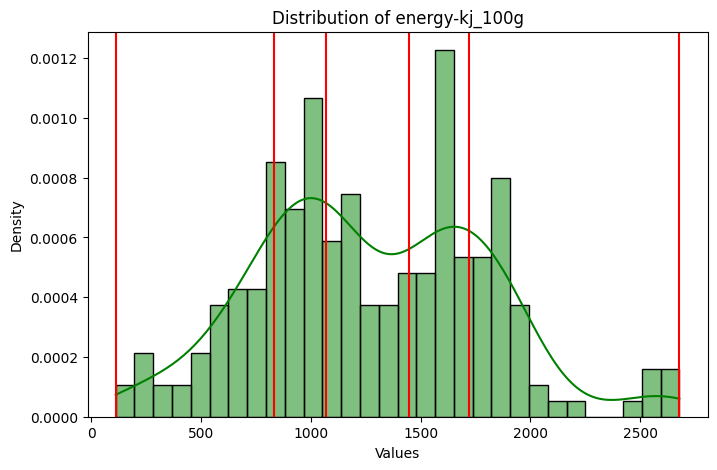

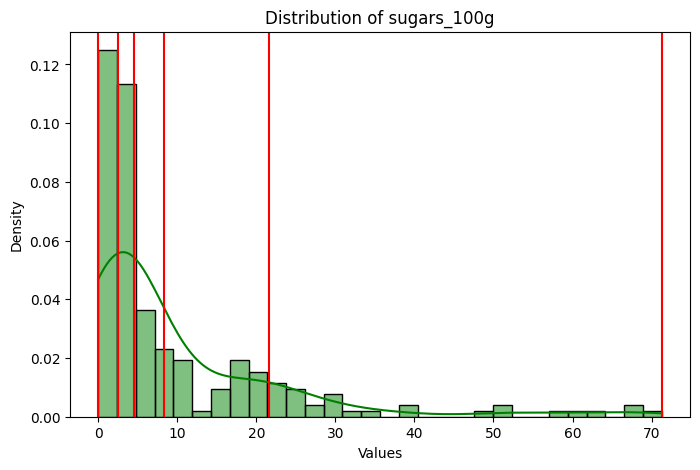

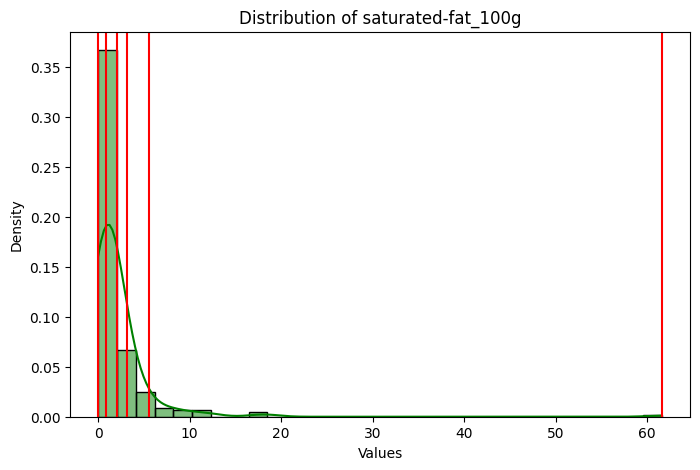

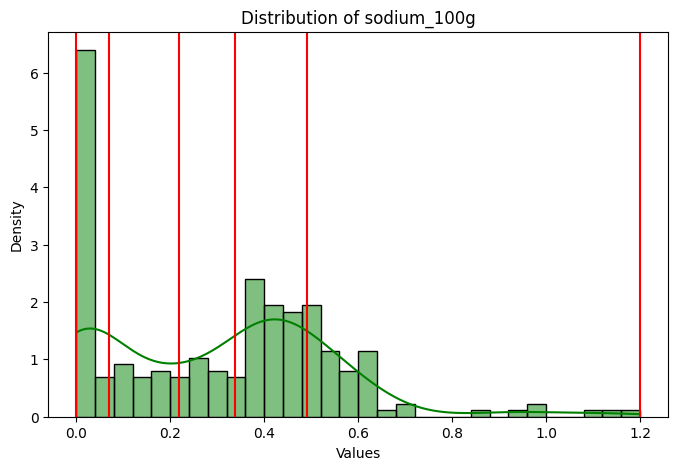

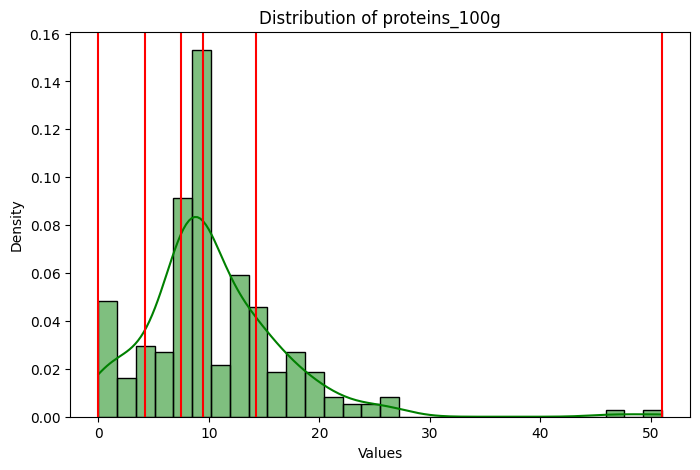

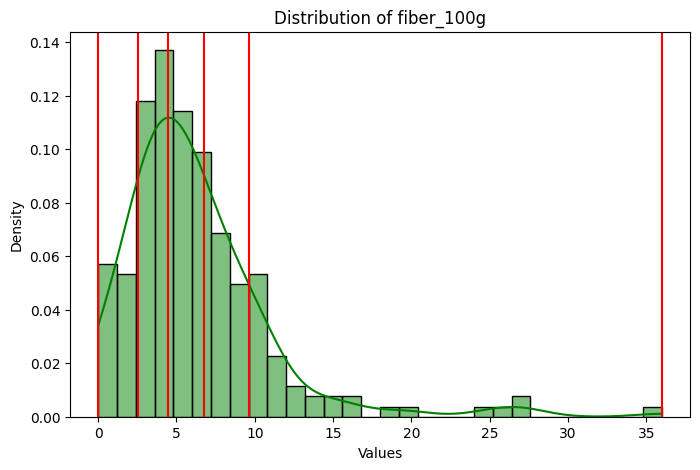

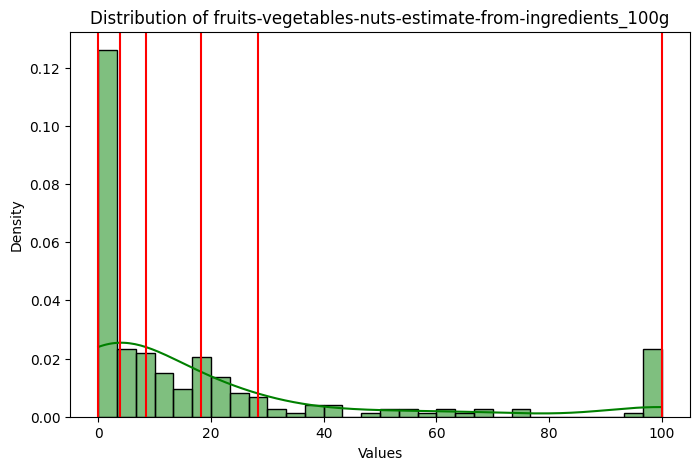

In [23]:
# Getting quantiles using numpy.percentile() for distinct columns values
quantiles = {}
for col in profiles.columns:
    quantiles[col] = np.percentile(profiles[col].unique(), [0, 20, 40, 60, 80, 100])

# Plotting distribution curves for each column
for col in profiles.columns:
    plt.figure(figsize=(8, 5))
    sns.histplot(profiles[col], kde=True, bins=30, color='green', stat='density')
    plt.title(f'Distribution of {col}')
    plt.xlabel('Values')
    plt.ylabel('Density')
    for q in quantiles[col]:
        plt.axvline(x=q, color='red')
    plt.show()

In [24]:
profile_dict = {}

# Creating a dictionary of criteria for each column
for col in profiles.columns:
    each_criteria = []
    for i in range(5):
        each_criteria.append((quantiles[col][i], quantiles[col][i+1]))
    profile_dict[col] = each_criteria

print(profile_dict)

{'energy-kj_100g': [(111.0, 832.2), (832.2, 1070.4), (1070.4, 1446.4), (1446.4, 1720.6000000000001), (1720.6000000000001, 2679.0)], 'sugars_100g': [(0.0, 2.54), (2.54, 4.58), (4.58, 8.34), (8.34, 21.60000000000001), (21.60000000000001, 71.3)], 'saturated-fat_100g': [(0.0, 0.8), (0.8, 2.0), (2.0, 3.2), (3.2, 5.6), (5.6, 61.6)], 'sodium_100g': [(0.0, 0.0704), (0.0704, 0.21760000000000002), (0.21760000000000002, 0.3376), (0.3376, 0.4904), (0.4904, 1.2)], 'proteins_100g': [(0.0, 4.2), (4.2, 7.5), (7.5, 9.5), (9.5, 14.3), (14.3, 51.0)], 'fiber_100g': [(0.0, 2.5460000000000003), (2.5460000000000003, 4.48), (4.48, 6.739999999999999), (6.739999999999999, 9.620000000000006), (9.620000000000006, 36.0)], 'fruits-vegetables-nuts-estimate-from-ingredients_100g': [(0.0, 3.9000000000000004), (3.9000000000000004, 8.455511363636361), (8.455511363636361, 18.21118377201144), (18.21118377201144, 28.28600000000001), (28.28600000000001, 100.0)]}


In [25]:
weights = [
    # {en: 1, su: 1, fa: 1, sa: 1, pr: 2, fi: 2, fr: 2}, #weights 1
    # {en: 2, su: 2, fa: 2, sa: 2, pr: 1, fi: 1, fr: 1}, #weights 2
    # {en: 0, su: 1, fa: 1, sa: 1, pr: 1, fi: 1, fr: 1}, #weights 3
    {en: 0, su: 2, fa: 4, sa: 0.8, pr: 2, fi: 1, fr: 0.5}, #our model
]

In [26]:
# def OptimisticMajoritySorting(data, profile_dict, weights):
#     # build MR-Sort based on the profile_dict and weights, return the data with the categories assiged to it
#     # loop over the data columns, check the value of each row use the weights it if it exceed the threshold y = 0.6, assign the category to the row
#     # if the row does not exceed the threshold, assign it to the next category
#     # reverse the profile_dict
#     for col in data.columns:
#         for i in range(len(profile_dict[col])):
#             # print(profile_dict[col][i])
#             # print(profile_dict[col][i][0])
#             # print(profile_dict[col][i][1])
#             # print(data[col])
#             # print((data[col] >= profile_dict[col][i][0]))
#             # print((data[col] <= profile_dict[col][i][1]))
#             # if the value of the row is between the range of the category, assign the category to the row by taking the threshold into account
#             data.loc[(data[col] >= profile_dict[col][i][0]) & (data[col] <= profile_dict[col][i][1]), col] = i
#             # return data
#     # data.to_csv('../data/preprocessed_elctri_model_col.csv', index=False) 
#     # calculate the score for each row
#     return data

In [27]:
def plot_confusion_matrices(data_50, data_60, data_70, type='Pessimistic'):
    datasets = {'(50%)': data_50, '(60%)': data_60, '(70%)': data_70}

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    for i, (dataset_name, dataset) in enumerate(datasets.items()):
        confusion_matrix = pd.crosstab(dataset['nutrition_grade_fr'], dataset['category'], rownames=['Actual'], colnames=['Predicted'])

        sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='d', ax=axs[i])
        axs[i].set_title(f'{type} Confusion Matrix {dataset_name}')
        axs[i].set_xlabel('Predicted')
        axs[i].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

In [28]:
def plot_barchart_matrices(data_50, data_60, data_70, type='Pessimistic'):    
    # Column names to plot from each DataFrame
    col_df1 = 'category'  # Change this to your desired column from df1

    # Create separate plots for each DataFrame
    fig, axs = plt.subplots(1,4, figsize=(12, 4))

    # Plotting DataFrame 1
    value_counts_70 = data_70[col_df1].value_counts()
    axs[0].bar(value_counts_70.index, value_counts_70.values, width=0.4, align='center', label='DF70')
    axs[0].set_title(f'{type} DataFrame 70%')

    # Plotting DataFrame 2
    value_counts_60 = data_60[col_df1].value_counts()
    axs[1].bar(value_counts_60.index, value_counts_60.values, width=0.4, align='center', label='DF60')
    axs[1].set_title(f'{type} DataFrame 60%')

    # Plotting DataFrame 3
    value_counts_50 = data_50[col_df1].value_counts()
    axs[2].bar(value_counts_50.index, value_counts_50.values, width=0.4, align='center', label='DF50')
    axs[2].set_title(f'{type} DataFrame 50%')

    # Plotting DataFrame 4
    value_counts_origianl = data_70['nutrition_grade_fr'].value_counts()
    axs[3].bar(value_counts_origianl.index, value_counts_origianl.values, width=0.4, align='center', label='Original')
    axs[3].set_title('Original')

    # Adding labels, legend, and adjusting layout
    for ax in axs:
        ax.set_xlabel('Category')
        ax.set_ylabel('Value Counts')
        ax.legend()
        
    plt.tight_layout()
    plt.show()

In [29]:
def OptimisticMajoritySorting(data_0, profile_dict, weights, thresholdPercentage, columns):
    """
    This function performs Optimistic Majority Sorting based on the profile_dict and weights.
    It assigns categories to the data based on the majority sorting algorithm.

    Parameters:
    - data_0: pandas DataFrame, the input data
    - profile_dict: dictionary, the profile dictionary containing the thresholds for each column
    - weights: list of dictionaries, the weights for each category
    - thresholdPercentage: float, the threshold percentage for the score
    - columns: list, the columns to consider for sorting

    Returns:
    - data: pandas DataFrame, the data with assigned categories
    """
    # Make a copy of the data
    data = data_0.copy()
    sum_of_weights = sum(weights[0].values())
    
    # calculate the threshold for the score based on the threshold percentage
    threshold = thresholdPercentage * (len(next(iter(profile_dict.items()))[1]) * sum_of_weights) / 100
    
    error_rate = 0.01  # The error rate for the algorithm
    
    # Iterate over each row and update cells based on conditions
    for index, row in data.iterrows():
        category_flag = False
        # i represents the category index
        for i in range(len(next(iter(profile_dict.items()))[1])):
            sum_v = 0  # sum of the weighted sum of the categories
            for col in columns:
                lower_bound = profile_dict[col][i][0]
                upper_bound = profile_dict[col][i][1]
                if ((lower_bound - error_rate) < row[col] < (upper_bound +error_rate)):
                    sum_v += weights[0][col] * sum_of_weights * (i + 1)
                    continue  # Stop checking for this column once a match is found
                else:
                    break
            if sum_v >= threshold:
                data.at[index, 'category'] = chr(69 - i)  # shift the category by 1
                category_flag = True
                break  # skip the rest of the categories
            else:
                continue
        if not category_flag:
            # print(sum_v, threshold)
            data.at[index, 'category'] = 'A'  # assign category 'E' if no category is assigned
    
    # Return the data with assigned categories
    return data

In [30]:
columns = [en, su, fa, sa, pr, fi, fr]
# use the fucntion OptimisticMajoritySorting
thresholdPercentage = 70
data_70 = pd.DataFrame(OptimisticMajoritySorting(df, profile_dict, weights, thresholdPercentage, columns))
# data_70.to_csv('../data/preprocessed_elctri_model_col.csv', index=False)
data_60 = pd.DataFrame(OptimisticMajoritySorting(df, profile_dict, weights, thresholdPercentage -10, columns))
data_50 = pd.DataFrame(OptimisticMajoritySorting(df, profile_dict, weights, thresholdPercentage - 20, columns))

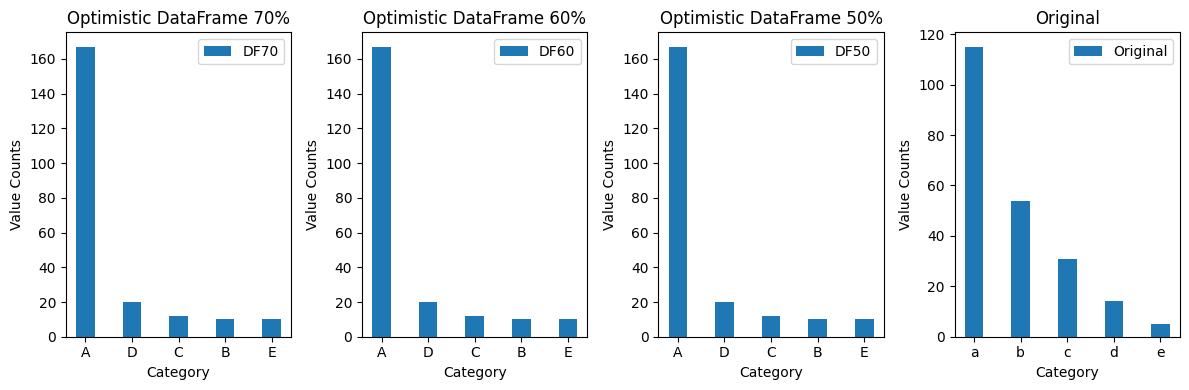

In [31]:
plot_barchart_matrices(data_50, data_60, data_70, type='Optimistic')

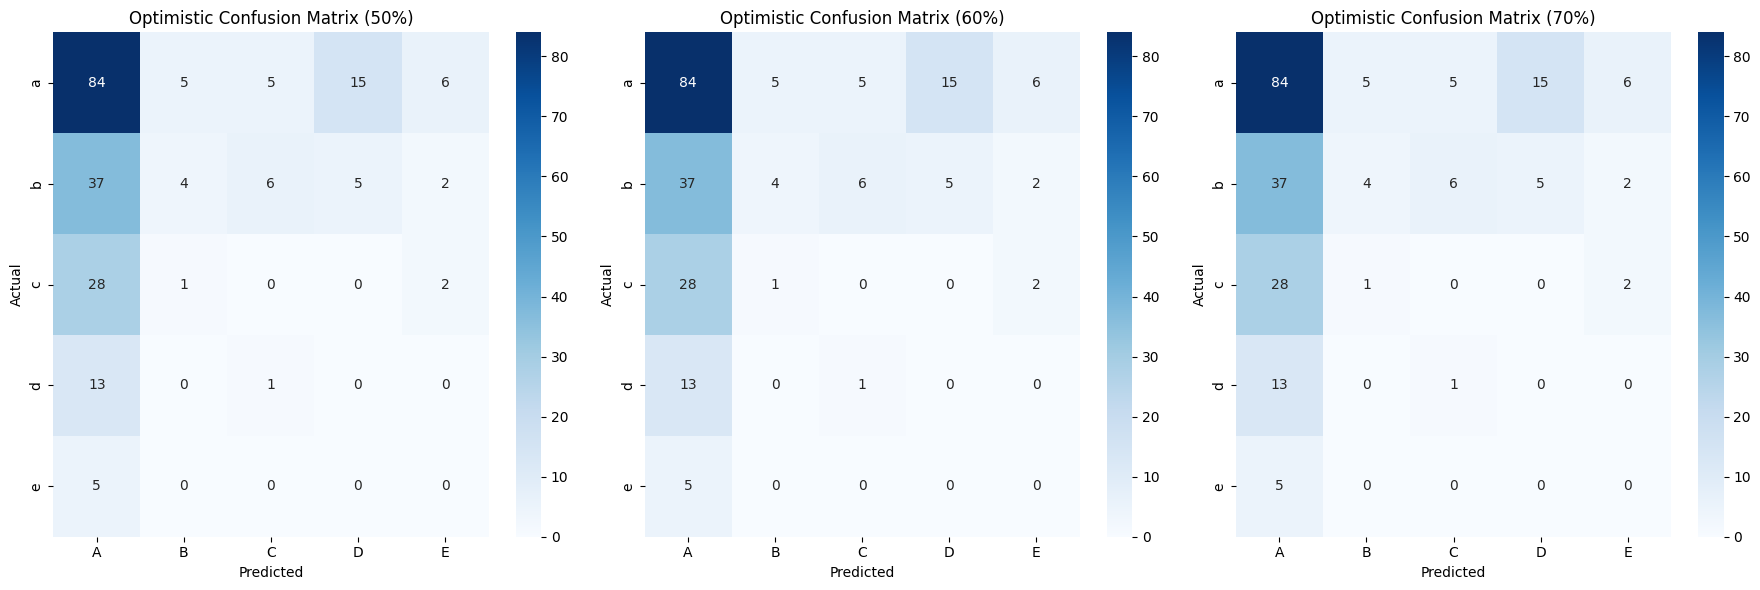

In [32]:
plot_confusion_matrices(data_50, data_60, data_70, type='Optimistic')

In [33]:
reversed_dict = {}

for key, value in profile_dict.items():
    reversed_tuples = [(tup[1], tup[0]) for tup in value[::-1]]  # Reversing the tuples elements
    reversed_dict[key] = reversed_tuples

print(reversed_dict)

{'energy-kj_100g': [(2679.0, 1720.6000000000001), (1720.6000000000001, 1446.4), (1446.4, 1070.4), (1070.4, 832.2), (832.2, 111.0)], 'sugars_100g': [(71.3, 21.60000000000001), (21.60000000000001, 8.34), (8.34, 4.58), (4.58, 2.54), (2.54, 0.0)], 'saturated-fat_100g': [(61.6, 5.6), (5.6, 3.2), (3.2, 2.0), (2.0, 0.8), (0.8, 0.0)], 'sodium_100g': [(1.2, 0.4904), (0.4904, 0.3376), (0.3376, 0.21760000000000002), (0.21760000000000002, 0.0704), (0.0704, 0.0)], 'proteins_100g': [(51.0, 14.3), (14.3, 9.5), (9.5, 7.5), (7.5, 4.2), (4.2, 0.0)], 'fiber_100g': [(36.0, 9.620000000000006), (9.620000000000006, 6.739999999999999), (6.739999999999999, 4.48), (4.48, 2.5460000000000003), (2.5460000000000003, 0.0)], 'fruits-vegetables-nuts-estimate-from-ingredients_100g': [(100.0, 28.28600000000001), (28.28600000000001, 18.21118377201144), (18.21118377201144, 8.455511363636361), (8.455511363636361, 3.9000000000000004), (3.9000000000000004, 0.0)]}


In [34]:
def PessimisticMajoritySorting(data_0, profile_dict, weights, thresholdPercentage, columns):
    """
    This function performs Pessimistic Majority Sorting based on the profile_dict and weights.
    It assigns categories to the data based on the majority sorting algorithm.

    Parameters:
    - data_0: pandas DataFrame, the input data
    - profile_dict: dictionary, the profile dictionary containing the thresholds for each column
    - weights: list of dictionaries, the weights for each category
    - thresholdPercentage: float, the threshold percentage for the score
    - columns: list, the columns to consider for sorting

    Returns:
    - data: pandas DataFrame, the data with assigned categories
    """
    # Make a copy of the data
    data = data_0.copy()
    sum_of_weights = sum(weights[0].values())
    
    # calculate the threshold for the score based on the threshold percentage
    threshold = thresholdPercentage * (len(next(iter(profile_dict.items()))[1]) * sum_of_weights) / 100
    
    error_rate = 0.01  # The error rate for the algorithm
    
    # Iterate over each row and update cells based on conditions
    for index, row in data.iterrows():
        category_flag = False
        # i represents the category index
        for i in range(len(next(iter(profile_dict.items()))[1])):
            sum_v = 0  # sum of the weighted sum of the categories
            for col in columns:
                lower_bound = profile_dict[col][i][1]
                upper_bound = profile_dict[col][i][0]
                if (upper_bound + error_rate) > row[col] > (lower_bound - error_rate):
                    sum_v += weights[0][col] * sum_of_weights * (i + 1)
                    continue  # Stop checking for this column once a match is found
                else:
                    break
            if sum_v >= threshold:
                data.at[index, 'category'] = chr(69 - i)  # shift the category by 1
                category_flag = True
                break  # skip the rest of the categories
            else:
                continue
        if not category_flag:
            data.at[index, 'category'] = 'A'  # assign category 'E' if no category is assigned
    
    # Return the data with assigned categories
    return data

In [35]:
columns = [en, su, fa, sa, pr, fi, fr]
# use the fucntion PessimisticMajoritySorting
thresholdPercentage = 70
data_70 = pd.DataFrame(PessimisticMajoritySorting(df, reversed_dict, weights, thresholdPercentage, columns))
# data_70.to_csv('../data/preprocessed_elctri_model_col.csv', index=False)
data_60 = pd.DataFrame(PessimisticMajoritySorting(df, reversed_dict, weights, thresholdPercentage -10, columns))
data_50 = pd.DataFrame(PessimisticMajoritySorting(df, reversed_dict, weights, thresholdPercentage - 20, columns))

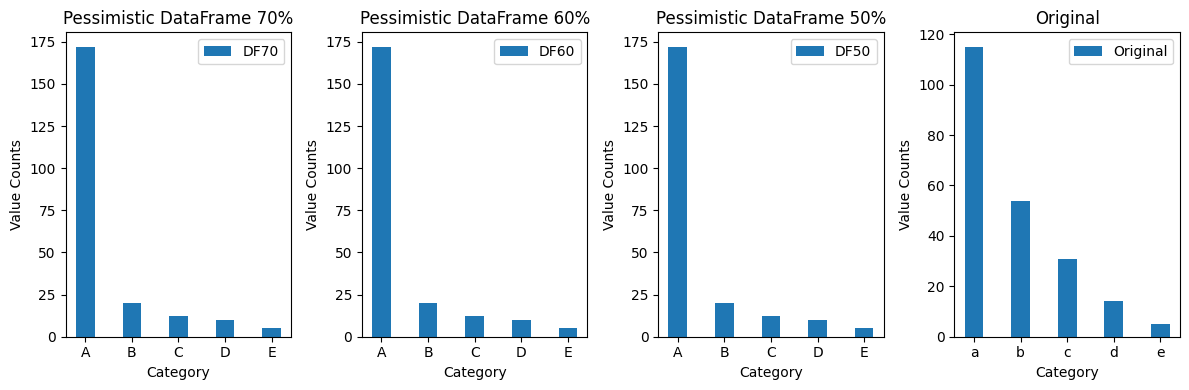

In [36]:
plot_barchart_matrices(data_50, data_60, data_70, type='Pessimistic')

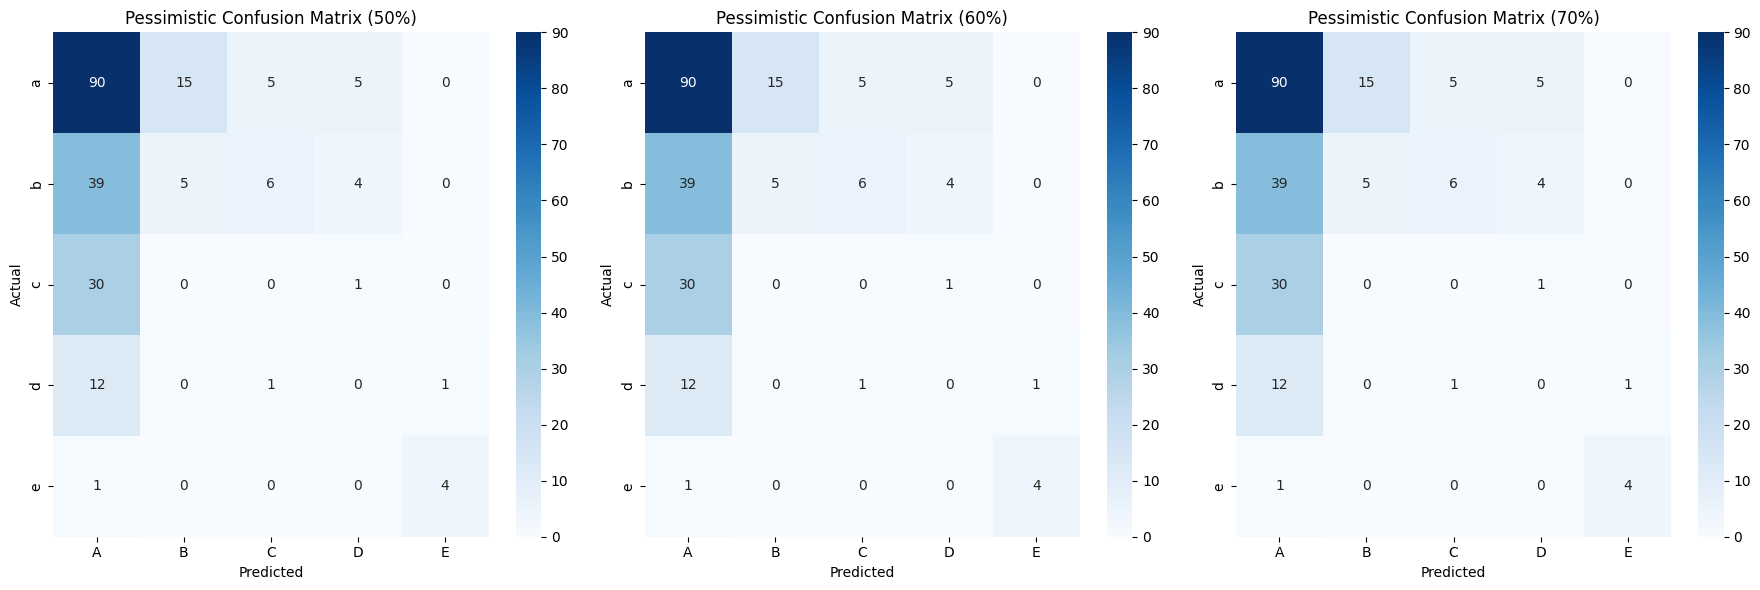

In [37]:
plot_confusion_matrices(data_50, data_60, data_70, type='Pessimistic')

In [38]:
# def PessimisticMajoritySorting(data_0, profile_dict, weights, thresholdPercentage):
#     """
#     This function performs Pessimistic Majority Sorting based on the profile_dict and weights.
#     It assigns categories to the data based on the majority sorting algorithm.

#     Parameters:
#     - data: pandas DataFrame, the input data
#     - profile_dict: dictionary, the profile dictionary containing the thresholds for each column
#     - weights: list of dictionaries, the weights for each category

#     Returns:
#     - data: pandas DataFrame, the data with assigned categories
#     """
#     # Make a copy of the data
#     data = pd.DataFrame.copy(data_0)
#     # define the columns 
#     columns = [en, su, fa, sa, pr, fi, fr]
#     error_rate = 0.001  # The error rate for the algorithm
#     # Iterate over each row and update cells based on conditions
#     for index, row in data.iterrows():
#         for col in columns:
#             for i in range(len(profile_dict[col])):
#                 lower_bound = profile_dict[col][i][1]
#                 upper_bound = profile_dict[col][i][0]
#                 if (lower_bound + error_rate) < row[col] <= (upper_bound + error_rate):
#                     data.at[index, col] = i +1 # shift the category by 1
#                     break  # Stop checking other ranges once a match is found
#     # for each column in the data, multiply the value of the row by the weight of the category
#     for col in columns:
#         for i in range(len(profile_dict[col])):
#             data.loc[data[col] == i, col] = weights[0][col] * i
#     # calculate the score for each row
#     data['score'] = data[columns].sum(axis=1)

#     # calculate the threshold for the score based on the threshold percentage
#     theshold = thresholdPercentage /100 * (len(next(iter(profile_dict.items()))[1]) * len(columns)) # the threshold for the score 50%

#     print(theshold)
#     # # assign the category between A, B, C, D, E based on the score and the threshold
#     for index, row in data.iterrows():
#         if row['score'] >= theshold:
#             data.at[index, 'category'] = 'A'
#         elif row['score'] >= theshold * 0.8:
#             data.at[index, 'category'] = 'B'
#         elif row['score'] >= theshold * 0.6:
#             data.at[index, 'category'] = 'C'
#         elif row['score'] >= theshold * 0.4:
#             data.at[index, 'category'] = 'D'
#         else:
#             data.at[index, 'category'] = 'E'

#     # # Save the data to a CSV file
#     # data.to_csv('../data/preprocessed_elctri_model_col.csv', index=False) 

#     # Return the data with assigned categories
#     return data